In [1]:
import os
import math

In [2]:
import ROOT as R
# import numpy as np

Welcome to JupyROOT 6.22/00


In [3]:
R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(16)
R.gStyle.SetPadRightMargin(0.05)
R.gStyle.SetPadLeftMargin(0.15)
R.gStyle.SetPadTopMargin(0.1)

In [4]:
def draw_labels(canv):
    scale = 800/600
#     scale = 600.0/800
    lumiTextSize = 0.6 * scale
    lumiTextOffset = 0.2 * scale
    muCTextSize = 0.75 * scale
    muCTextOffset = 0.1 * scale
    relPosX = 0.045 * scale
    relPosY = 0.035 * scale
    relExtraText = 1.2

    l = canv.GetLeftMargin()
    t = canv.GetTopMargin()
    r = canv.GetRightMargin()
    b = canv.GetBottomMargin()

    latex = R.TLatex()
    latex.SetNDC()
    latex.SetTextAngle(0)
    latex.SetTextColor(R.kBlack)
    extraTextSize = 0.76*muCTextSize
    latex.SetTextFont(42)
    latex.SetTextAlign(31)
    latex.SetTextSize(lumiTextSize*t)
    latex.DrawLatex(1-r, 1-t+lumiTextOffset*t, "#sqrt{s}=1.5TeV")
    posX_=   l + relPosX*(1-l-r);
    posY_ = 1-t - relPosY*(1-t-b)
    latex.SetTextFont(61)
    latex.SetTextSize(muCTextSize*t)
    latex.SetTextAlign(13)
    latex.DrawLatex(posX_, posY_, "Muon Collider")
    latex.SetTextFont(52)
    latex.SetTextAlign(13)
    latex.SetTextSize(extraTextSize*t)
    latex.DrawLatex(posX_, posY_ - relExtraText*muCTextSize*t, "Simulation")

In [5]:
def draw(histos, config, out_file=None):
    size = (800, 800)
    if 'canvas' in config:
        size = config['canvas']
    C = R.TCanvas("canvas", "", size[0], size[1])
    C.SetGridx()
    C.SetGridy()
    R.SetOwnership(C, False)
    n = len(histos)
    leg = None
    if 'leg' in config:
        leg = R.TLegend(0.67,0.95-n*0.07, 0.95,0.95)
        leg.SetMargin(0.25)
        leg.SetTextSize(0.04)
        R.SetOwnership(leg, 0)
    h_axis = None
    h_toDraw = []
    for iH, h_ori in enumerate(histos):
        h = h_ori.Clone()
        if iH == 0:
            h_axis = h
        if 'rebin' in config:
            h.Rebin(config['rebin'])
#         h.Rebin(2)
        if 'norm' in config:
            h.Scale(config['norm'] / h.Integral())
        R.SetOwnership(h, 0)
        h.SetLineWidth(2)
        if 'style' in config:
            h.SetLineStyle(config['style'][iH])
        h.SetLineColor(config['color'][iH])
#         h.SetLineColor(1)
#         h.SetFillColor(config['color'][iH])
        if leg:
#             leg.AddEntry(h, config['leg'][iH], 'l')
            leg.AddEntry(h, config['leg'][iH], 'l').SetTextColor(config['color'][iH])
        h_toDraw.append(h)
    # Actually drawing
    h_axis.Draw('AXIS')
    h_axis.Draw('AXIG same')
    for iH, h in enumerate(h_toDraw):
        drawopt = 'hist'
        if 'drawopt' in config:
            drawopt = config['drawopt']
        drawopt += "same"
        h.Draw(drawopt)
    h_axis.Draw('AXIG same')
    if leg:
        leg.Draw()
        h_axis.GetYaxis().SetMaxDigits(4)
    if 'y' in config:
        h_axis.GetYaxis().SetRangeUser(*config['y'])
    if 'x' in config:
        h_axis.GetXaxis().SetRangeUser(*config['x'])
    if 'logY' in config:
        C.SetLogy(config['logY'])
    if 'logX' in config:
        C.SetLogx(config['logX'])
    C.RedrawAxis()
    draw_labels(C)
    
    C.Draw()
    if out_file:
        C.Print(out_file)

### BIB input MCParticle properties

In [8]:
# DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep'
# FILE_IN = os.path.join(DIR_IN, 'slcio/bib_mcp.root')
DIR_OUT = '/Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/'
FILE_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/data/bib_mcp.root'
file_in = R.TFile(FILE_IN)
tree = file_in.Get('MyLCTuple')

In [64]:
pdgs = [2112, 22, 11]
histos = [R.TH1F('h{0:d}'.format(i), ';Momentum [MeV];BIB Particles', 60, 0, 300) for i in range(len(pdgs))]
for i, pdg in enumerate(pdgs):
    nev = tree.Draw('sqrt(mcmox*mcmox + mcmoy*mcmoy + mcmoz*mcmoz)*1e3>>h{0:d}'.format(i), 'abs(mcpdg) == {0:d}'.format(pdg), 'goff')
    print(pdg, nev)

2112 175926270
22 201402890
11 1755520


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/plots/mcp_p.eps has been created


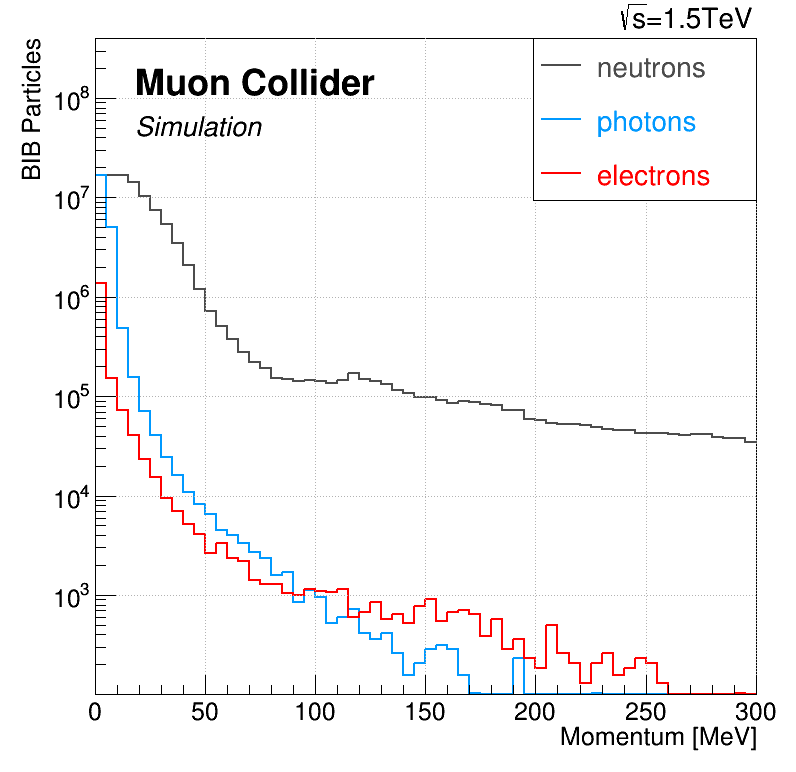

In [65]:
R.gStyle.SetPadTopMargin(0.05)
R.gStyle.SetPadLeftMargin(0.12)
draw(histos, {'color': [12, R.kAzure+7, 2],
              'leg': [' neutrons', ' photons', ' electrons'],
              'y': (1e2, 4e8),
              'x': (0, 300),
#               'norm': 90,
              'logY': True
#              }, None)
             }, os.path.join(DIR_OUT, 'plots/mcp_p.eps'))

### Vertex Z position

In [66]:
pdgs = [2112, 22, 11]
histos = [R.TH1F('hz{0:d}'.format(i), ';|Z| position [cm];BIB Particles', 100, 0, 500) for i in range(len(pdgs))]
for i, pdg in enumerate(pdgs):
    nev = tree.Draw('abs(mcvtz)/10.0>>hz{0:d}'.format(i), 'abs(mcpdg) == {0:d}'.format(pdg), 'goff')
    print(pdg, nev)

2112 175926270
22 201402890
11 1755520


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/plots/mcp_z.eps has been created


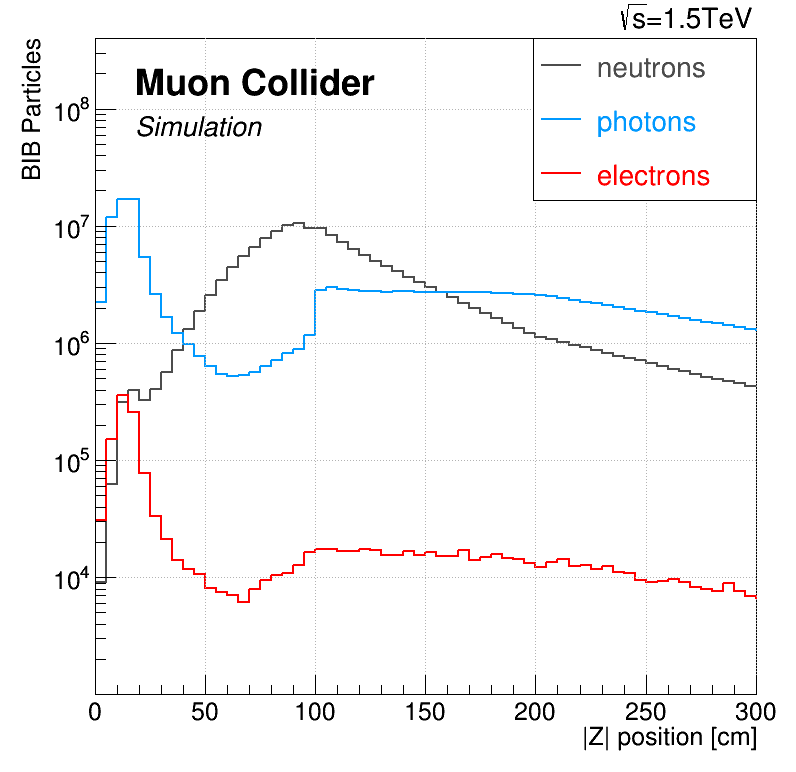

In [67]:
draw(histos, {'color': [12, R.kAzure+7, 2],
              'leg': [' neutrons', ' photons', ' electrons'],
              'y': (1e3, 4e8),
              'x': (0, 300),
              'logY': True
#              }, None)
             }, os.path.join(DIR_OUT, 'plots/mcp_z.eps'))

### Time

In [68]:
pdgs = [2112, 22, 11]
histos = [R.TH1F('hc{0:d}'.format(i), ';Arrival time [ns];BIB Particles', 250, -50, 200) for i in range(len(pdgs))]
for i, pdg in enumerate(pdgs):
    nev = tree.Draw('mctim>>hc{0:d}'.format(i), 'abs(mcpdg) == {0:d}'.format(pdg), 'goff')
    print(pdg, nev)

2112 175926270
22 201402890
11 1755520


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/plots/mcp_t.eps has been created


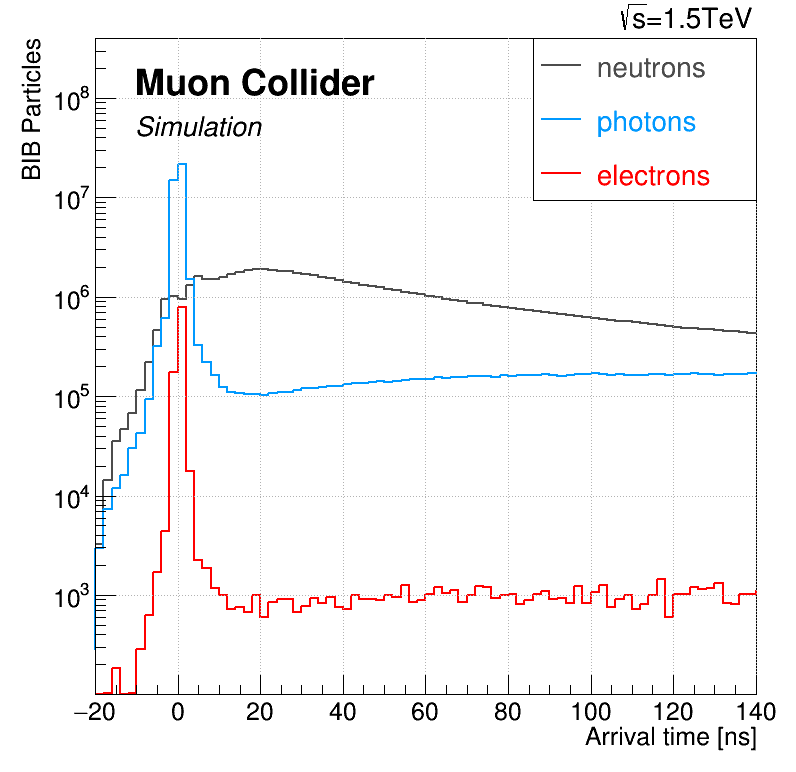

In [69]:
draw(histos, {'color': [12, R.kAzure+7, 2],
              'leg': [' neutrons', ' photons', ' electrons'],
              'y': (1e2, 4e8),
              'x': (-20, 140),
              'logY': True,
              'rebin': 2,
#              }, None)
             }, os.path.join(DIR_OUT, 'plots/mcp_t.eps'))

### Vertex Layout

In [34]:
histos = [R.TH1F('hv'.format(i), ';Z [cm];Particles / 0.5 cm', 200, -50, 50)]
nev = tree.Draw('mcvtz/10.0 >> hv'.format(i), '', 'goff')
print(nev)

379161510


Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: hv (Potential memory leak).


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas
Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/plots/vxd_layout.eps has been created


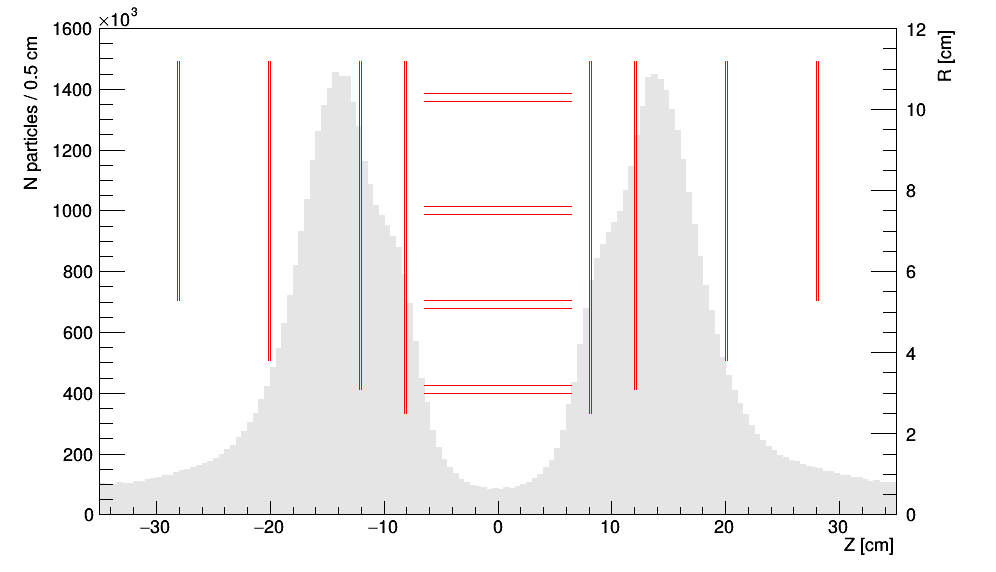

In [97]:
ymaxP = 16e5
ymaxR = 12
cr = ymaxP / ymaxR
C = R.TCanvas("canvas", "", 1000, 600)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.1)
# C.SetGridx()
# C.SetGridy()
R.SetOwnership(C, False)
h_axis = None
h_toDraw = []
for iH, h_ori in enumerate(histos):
    h = h_ori.Clone()
    if iH == 0:
        h_axis = h
    R.SetOwnership(h, 0)
#     h.SetLineWidth(2)
    h.SetLineColor(18)
    h.SetFillColor(18)
    h_toDraw.append(h)
# Adding second axis
h_axis.GetYaxis().SetTitleOffset(1.2)
ax2 = R.TGaxis(35,0,35,ymaxP,0,ymaxR,510,"+L")
ax2.SetLabelFont(h_axis.GetYaxis().GetLabelFont())
ax2.SetLabelSize(h_axis.GetYaxis().GetLabelSize())
ax2.SetTitleFont(h_axis.GetYaxis().GetTitleFont())
ax2.SetTitleSize(h_axis.GetYaxis().GetTitleSize())
ax2.SetLabelOffset(0.01)
ax2.SetTitle('R [cm]')
ax2.SetTitleOffset(0.9)
# Actually drawing
h_axis.Draw('AXIS')
h_axis.Draw('AXIG same')
for iH, h in enumerate(h_toDraw):
    drawopt = 'hist'
    drawopt += "same"
    h.Draw(drawopt)
h_axis.Draw('AXIG same')
ax2.Draw()
h_axis.GetYaxis().SetRangeUser(0, 16e5)
h_axis.GetXaxis().SetRangeUser(-35, 35)
# Drawing VTX Barrel layers
br = [30, 32, 51, 53, 74, 76, 102, 104]
bz = 65
for r in br:
    l = R.TLine(-bz/10, cr*r/10, bz/10, cr*r/10)
    R.SetOwnership(l, False)
    l.SetLineWidth(1)
    l.SetLineColor(2)
    l.Draw()
# Drawing VTX Endcap disks
ez = [80, 82, 120, 122, 200, 202, 280, 282]
er = [25, 25, 31, 31, 38, 38, 53, 53]
er_max = 112
for iD, z in enumerate(ez):
    for side in [-1, 1]:
        l = R.TLine(side*z/10, cr*er[iD]/10, side*z/10, cr*er_max/10)
        R.SetOwnership(l, False)
        l.SetLineWidth(1)
        l.SetLineColor(2)
        l.Draw()
C.RedrawAxis()
C.Draw()
C.Print(os.path.join(DIR_OUT, 'plots/vxd_layout.eps'))

### Drawing tracker hit time distributions

In [49]:
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep'
# DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2021_06_12_vchep/root'
files = [os.path.join(DIR_IN, 'slcio', p) for p in ['pgun_mu_tuple_trk.root', 'mumi-1e3x500-26m-lowth-excl_tuple_trk.root']]
files_in = [R.TFile(path) for path in files]
trees = [f.Get('MyLCTuple') for f in files_in]
histos = [R.TH1F('h_{0:d}'.format(i), ';t_{hit} - TOF_{photon} [ns];Hits [a.u.]', 400, -2, 3) for i in range(4)]

# cmd = '(thtim - sqrt(thpox*thpox + thpoy*thpoy + thpoz*thpoz)/299.8e6)'
cmd = 'thtim'
trees[0].Draw(cmd + ' >> h_1', 'thori <= 2', 'goff')
trees[0].Draw(cmd + ' >> h_0', 'thori > 2', 'goff')
trees[1].Draw(cmd + ' >> h_3', 'thori <= 2', 'goff')
trees[1].Draw(cmd + ' >> h_2', 'thori > 2', 'goff')
# for iT, t in enumerate(trees):
#     n = t.Draw('(thtim - sqrt(thpox*thpox + thpoy*thpoy + thpoz+thpoz)/299.8e6)*1e3 >> h_{0:d}'.format(iT), 'thori < 2', 'goff')
#     print(iT, n)
    
# histos = {R.TH1F('hv'.format(i), ';Z [cm];Particles / 0.5 cm', 200, -50, 50)}
# nev = tree.Draw('mcvtz/10.0 >> hv'.format(i), '', 'goff')
# print(nev)

3961077

In [60]:
C = R.TCanvas('ctime', '', 1000, 700)
C.SetGrid(0,0)
C.SetTopMargin(0.05)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.05)

Warning in <TCanvas::Constructor>: Deleting canvas with same name: ctime


In [61]:
colors = [ 17, R.kRed-9, 1, 2]

Info in <TCanvas::Print>: pdf file /Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/plots/hit_time_trk.pdf has been created


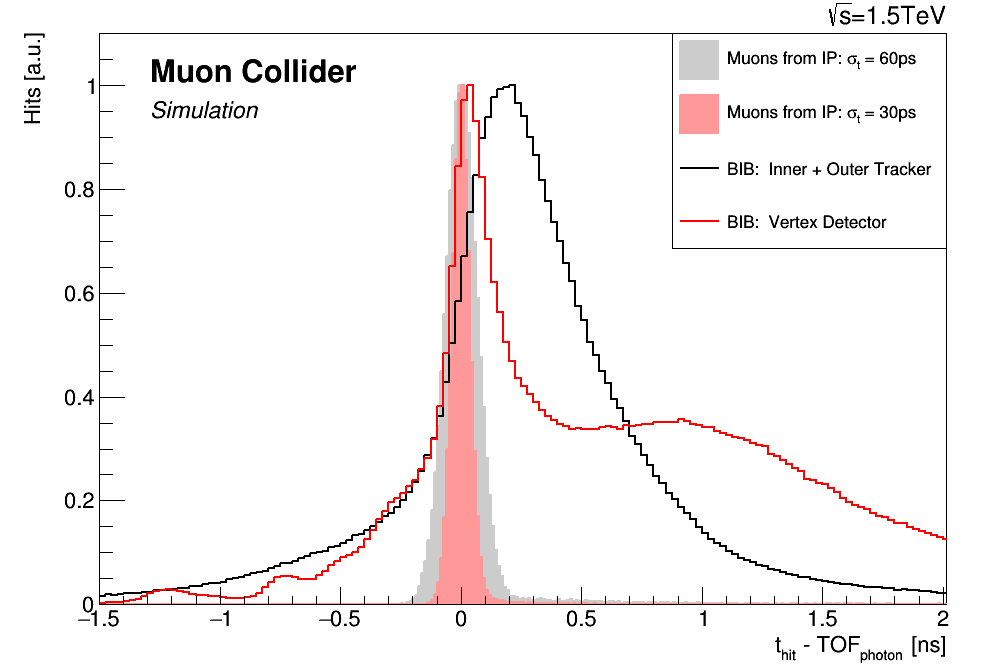

In [62]:
leg = R.TLegend(0.675,0.63, 0.95,0.95)
leg.SetEntrySeparation(0.0)
leg.SetMargin(0.2)
leg.SetTextSize(0.027)
titles = ['Muons from IP: #sigma_{t} = 60ps', 'Muons from IP: #sigma_{t} = 30ps', 'BIB:  Inner + Outer Tracker', 'BIB:  Vertex Detector']
l1 = R.TLine(-0.09, 0, -0.09, 1.04)
l2 = R.TLine(0.09, 0, 0.09, 1.04)
for l in [l1, l2]:
    l.SetLineColor(colors[1])
    l.SetLineWidth(2)
    l.SetLineStyle(7)
for iH, histo in enumerate(histos):
    h = histo.Clone()
    R.SetOwnership(h, False)
    if iH > 1:
        h.Rebin(2)
    h.Scale(1.0/h.GetMaximum())
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)
    h.SetAxisRange(-1.5, 2.0, 'X')
    if iH < 2:
        h.SetFillColor(colors[iH])
        h.GetXaxis().SetTitleOffset(1.2)
        h.SetAxisRange(0, 1.1, 'Y')
    if iH < 2:
        leg.AddEntry(h, titles[iH], 'F')
    else:
        leg.AddEntry(h, titles[iH], 'L')
    opt = '' if iH == 0 else 'same'
    h.Draw('hist'+opt)
# leg.AddEntry(l1, '#pm3#sigma_{t} time window', 'L')
leg.Draw()
# l1.Draw()
# l2.Draw()
C.RedrawAxis()
draw_labels(C)
C.Draw()
C.SaveAs(os.path.join(DIR_OUT, 'plots/hit_time_trk.pdf'))

### Drawing calorimeter hit time distributions

In [398]:
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep'
# DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2021_06_12_vchep/root'
files = [os.path.join(DIR_IN, 'slcio', p) for p in ['mumu2H2bb750_tuple_cal.root', 'sim_mumi-1e3x500-26m-lowth-excl_tuple_cal.root']]
files_in = [R.TFile(path) for path in files]
trees = [f.Get('MyLCTuple') for f in files_in]
histos = [R.TH1F('h_{0:d}'.format(i), ';t_{hit} - TOF_{photon} [ns];ECAL Barrel hits [a.u.]', 200, -1.0, 2.5) for i in range(2)]

cmd = 'catim - 0.1'
print(trees[0].Draw(cmd + ' >> h_0', 'caori == 1', 'goff'))
# print(trees[0].Draw(cmd + ' >> h_0', 'caori == 3', 'goff'))
print(trees[1].Draw(cmd + ' >> h_1', 'caori == 1', 'goff'))
# print(trees[1].Draw(cmd + ' >> h_3', 'caori == 4', 'goff'))

30629343
2695120


Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/plots/hit_time_ecal.eps has been created


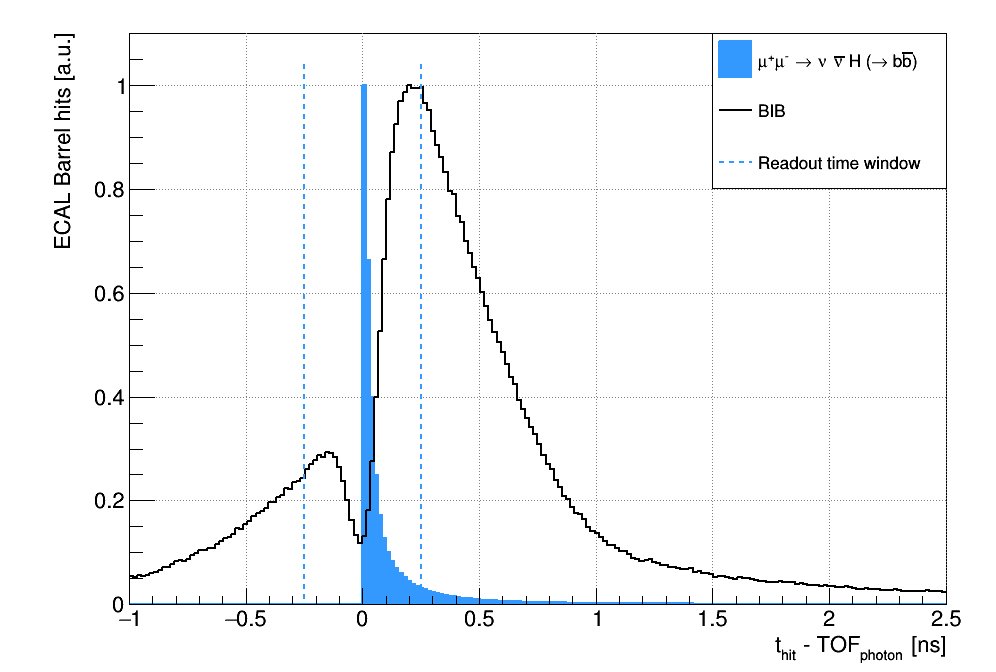

In [401]:
colors = [ R.kAzure+1, 1]
leg = R.TLegend(0.715,0.72, 0.95,0.95)
leg.SetEntrySeparation(0.0)
leg.SetMargin(0.2)
leg.SetTextSize(0.027)
titles = ['#mu^{+}#mu^{-} #rightarrow #nu #bar{#nu} H (#rightarrow b#bar{b})', 'BIB']
l1 = R.TLine(-0.25, 0, -0.25, 1.04)
l2 = R.TLine(0.25, 0, 0.25, 1.04)
for l in [l1, l2]:
    l.SetLineColor(colors[0])
    l.SetLineWidth(2)
    l.SetLineStyle(7)
for iH, histo in enumerate(histos):
    h = histo.Clone()
    R.SetOwnership(h, False)
#     if iH > 1:
#         h.Rebin(2)
    h.Scale(1.0/h.GetMaximum())
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)
    if iH == 0:
        h.SetFillColor(colors[iH])
        h.GetXaxis().SetTitleOffset(1.2)
        h.SetAxisRange(0, 1.1, 'Y')
    if iH == 0:
        leg.AddEntry(h, titles[iH], 'F')
    else:
        leg.AddEntry(h, titles[iH], 'L')
    opt = '' if iH == 0 else 'same'
    h.Draw('hist'+opt)
leg.AddEntry(l1, 'Readout time window', 'L')
leg.Draw()
l1.Draw()
l2.Draw()
C.RedrawAxis()
C.Draw()
C.SaveAs(os.path.join(DIR_IN, 'plots/hit_time_ecal.eps'))

In [390]:
histos = [R.TH1F('h_{0:d}'.format(i), ';Longitudinal hit position [mm];ECAL Barrel hits [a.u.]', 70, -50, 300) for i in range(2)]

cmd = 'sqrt(capox*capox + capoy*capoy) - 1500'
print(trees[0].Draw(cmd + ' >> h_0', '(caori == 1 && abs(catim - 0.1) < 0.25)*caene', 'goff'))
# print(trees[0].Draw(cmd + ' >> h_0', 'caori == 3', 'goff'))
print(trees[1].Draw(cmd + ' >> h_1', '(caori == 1 && abs(catim - 0.1) < 0.25)*caene', 'goff'))
# print(trees[1].Draw(cmd + ' >> h_3', 'caori == 4', 'goff'))

25386550
700258


Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_0 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_1 (Potential memory leak).


Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/plots/hit_depth_ecal.eps has been created


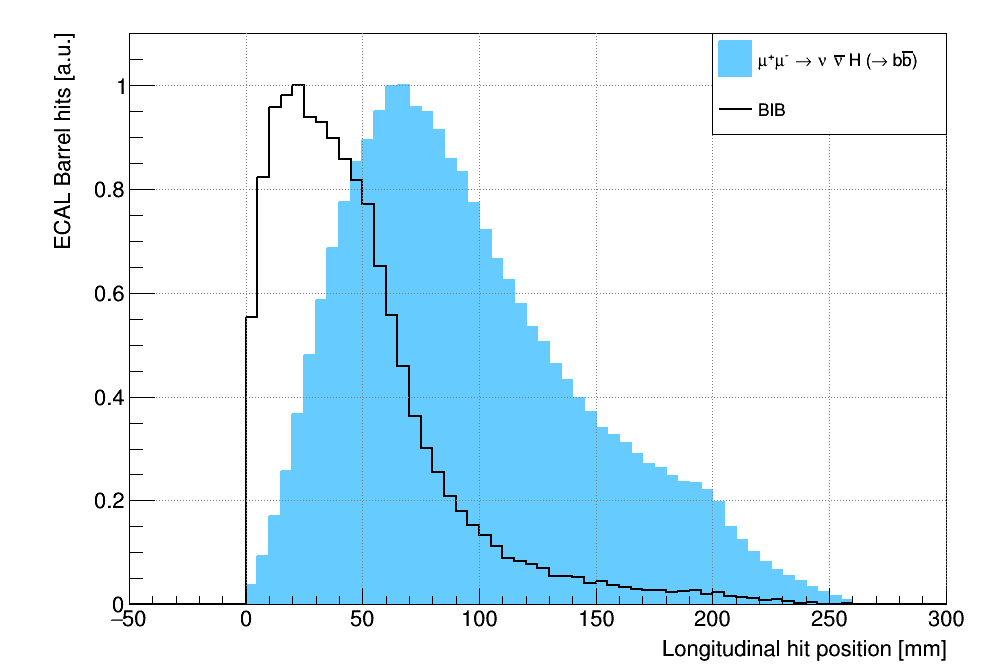

In [397]:
colors = [ R.kAzure+6, 1]
leg = R.TLegend(0.715,0.8, 0.95,0.95)
leg.SetEntrySeparation(0.0)
leg.SetMargin(0.2)
leg.SetTextSize(0.027)
titles = ['#mu^{+}#mu^{-} #rightarrow #nu #bar{#nu} H (#rightarrow b#bar{b})', 'BIB']
for l in [l1, l2]:
    l.SetLineColor(colors[0])
    l.SetLineWidth(2)
    l.SetLineStyle(7)
ah = None
for iH, histo in enumerate(histos):
    h = histo.Clone()
    R.SetOwnership(h, False)
#     if iH > 1:
#         h.Rebin(2)
    h.Scale(1.0/h.GetMaximum())
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)
    if iH == 0:
        h.SetFillColor(colors[iH])
        h.GetXaxis().SetTitleOffset(1.2)
        h.SetAxisRange(0, 1.1, 'Y')
        ah = h
    if iH == 0:
        leg.AddEntry(h, titles[iH], 'F')
    else:
        leg.AddEntry(h, titles[iH], 'L')
    opt = '' if iH == 0 else 'same'
    h.Draw('hist'+opt)
ah.Draw('AXIG same')
C.RedrawAxis()
leg.Draw()
C.Draw()
C.SaveAs(os.path.join(DIR_IN, 'plots/hit_depth_ecal.eps'))

### Drawing general hit time distributions

In [474]:
DIR_IN = '/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep'
# DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2021_06_12_vchep/root'
files = [os.path.join(DIR_IN, 'slcio', p) for p in ['sim_mumi-1e3x500-26m-lowth-excl_tuple_cal_ext.root']]
files_in = [R.TFile(path) for path in files]
trees = [f.Get('MyLCTuple') for f in files_in]
histos = [R.TH1F('h_{0:d}'.format(i), ';t_{hit} - TOF_{photon} [ns];Hits [a.u.]', 120, -20, 100) for i in range(3)]

cmd = 'catim'
print(trees[0].Draw('sttim - sqrt(stpox*stpox + stpoy*stpoy + stpoz*stpoz)/299.8e3 >> h_0', '', 'goff'))
print(trees[0].Draw('catim >> h_1', 'caori <= 2', 'goff'))
print(trees[0].Draw('catim >> h_2', 'caori > 2', 'goff'))

9472492
17152368
950730


Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/plots/bib_hit_time.eps has been created


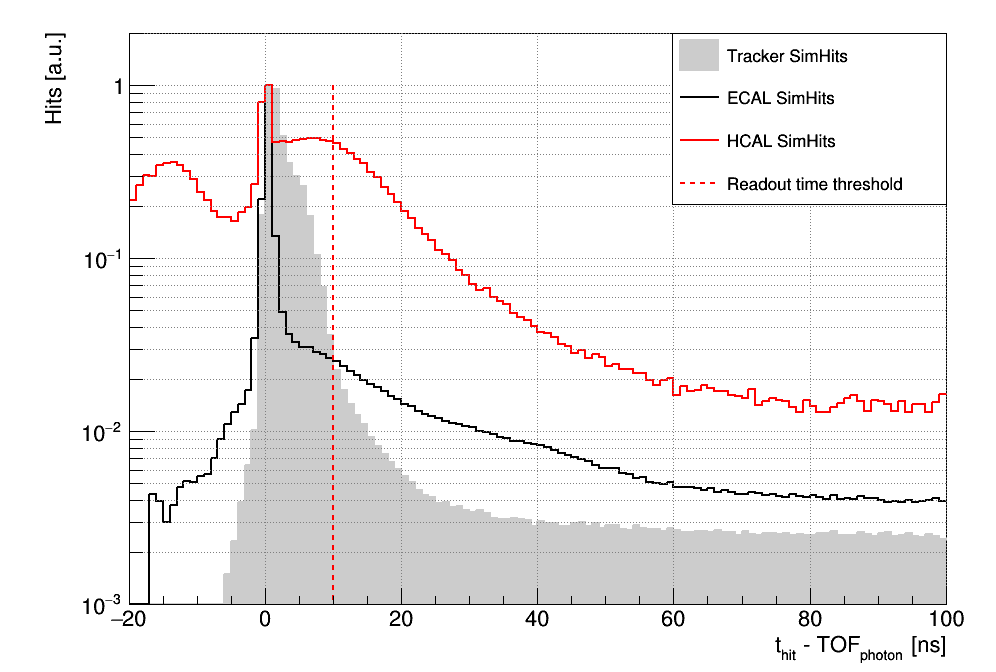

In [476]:
colors = [ 17, 1, 2]
leg = R.TLegend(0.675,0.695, 0.95,0.95)
leg.SetEntrySeparation(0.0)
leg.SetMargin(0.2)
leg.SetTextSize(0.027)
titles = ['Tracker SimHits', 'ECAL SimHits', 'HCAL SimHits']
l1 = R.TLine(10, 0, 10, 1.0)
C.SetLogy(True)
ha = None
for l in [l1]:
    l.SetLineColor(2)
    l.SetLineWidth(2)
    l.SetLineStyle(7)
for iH, histo in enumerate(histos):
    h = histo.Clone()
    R.SetOwnership(h, False)
#     if iH > 1:
#         h.Rebin(2)
    h.Scale(1.0/h.GetMaximum())
    h.SetLineColor(colors[iH])
    h.SetLineWidth(2)
    if iH == 0:
        h.SetFillColor(colors[iH])
        h.GetXaxis().SetTitleOffset(1.2)
        h.SetAxisRange(1e-3, 2, 'Y')
        ha = h
    if iH == 0:
        leg.AddEntry(h, titles[iH], 'F')
    else:
        leg.AddEntry(h, titles[iH], 'L')
    opt = '' if iH == 0 else 'same'
    h.Draw('hist'+opt)
ha.Draw('AXIG same')
leg.AddEntry(l1, 'Readout time threshold', 'L')
leg.Draw()
l1.Draw()
C.RedrawAxis()
C.Draw()
C.SaveAs(os.path.join(DIR_IN, 'plots/bib_hit_time.eps'))

### Drawing hit multiplicities with different hit selections

In [71]:
DIR_IN = '/Users/nbartosi/pdc/muoncdata/users/bartosik/clic/studies/2020_11_11_tracking/digi'
FILES_IN = [os.path.join(DIR_IN, f) for f in [
    'pgun_mu_1per10k_6pBIBTrimmed_dPhiCut_j3_hitMult.root',
    'pgun_mu_1per10k_6pBIBTrimmed_dPhiCut_j3_hitMult_DL.root',
    'pgun_mu_1per10k_6pBIBTrimmed_dPhiCut_j3_hitMult_DL2.root'
]]

In [72]:
histos = {}
hnames = ['h_nhits_sum', 'h_nhits_max', 'h_nhits_median']
for iF, file_in in enumerate(FILES_IN):
    hs = {}
    fIn = R.TFile(file_in)
    for hname in hnames:
        h = fIn.Get(hname).Clone()
        h.SetDirectory(0)
        R.SetOwnership(h, False)
        hs[hname] = h
    histos[iF] = hs
    fIn.Close()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h_axis (Potential memory leak).
Info in <TCanvas::Print>: eps file /Users/nbartosi/cernbox/work/mu_collider/snowmass_2022/plots/hit_mult_dl.eps has been created


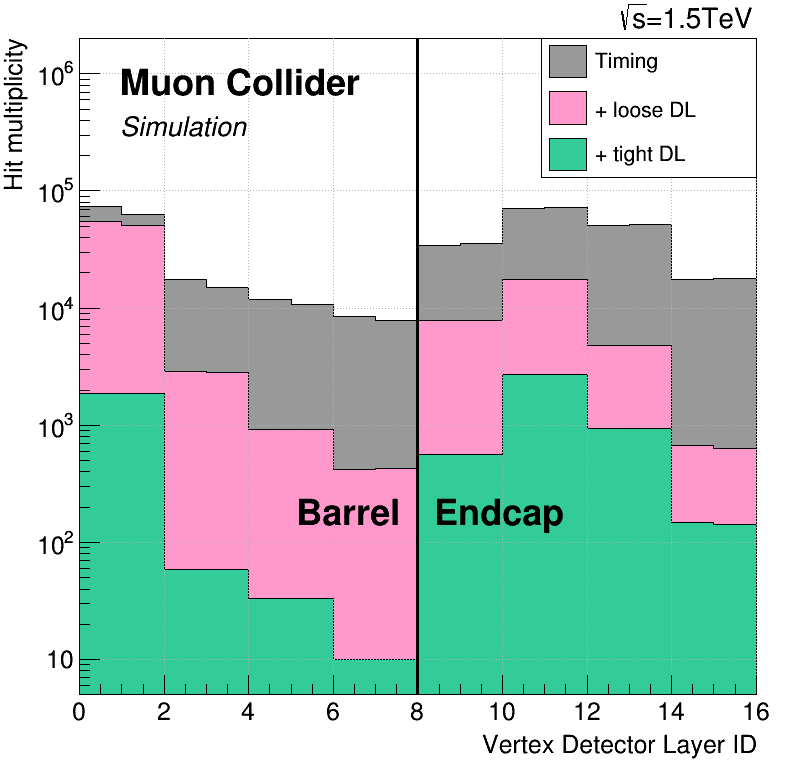

In [77]:
colors = [14, R.kAzure-2, R.kPink+7, R.kSpring+7]
R.gStyle.SetOptStat(0)
R.gStyle.SetGridColor(16)
C = R.TCanvas('c1', '', 800,800)
C.SetTopMargin(0.05)
C.SetLeftMargin(0.1)
C.SetRightMargin(0.05)
C.SetGrid(1,1)
C.SetLogy(True)
leg = R.TLegend(0.68,0.77,0.95,0.95)
# leg = R.TLegend(0.312,0.82,0.95,0.9)
# leg.SetNColumns(3)
leg.SetTextSize(0.03)
# ha = R.TH1F('h_axis', ';Layer;N reco hits (total)', 1, 0, 33)
ha = R.TH1F('h_axis', ';Vertex Detector Layer ID;Hit multiplicity', 1, 0, 16)
ha.SetAxisRange(5, 2e6, 'Y')
ha.Draw('AXIS')
legends = ['Timing', '+ loose DL', '+ tight DL']
colors = [16, 2, R.kSpring-8, R.kPink-2]
fillColors = [R.kGray+1, R.kPink+1, R.kTeal-5]
l1 = R.TLine(8, 0, 8, 2e6)
l1.SetLineWidth(3)
# legends = ['All hits', 'DL filtered']
for iH, name in enumerate(legends):
    h = histos[iH]['h_nhits_sum'].Clone()
    h.SetDirectory(0)
    R.SetOwnership(h, False)
    h.SetLineColor(1)
    h.SetFillColor(fillColors[iH])
    h.SetLineWidth(1)
    leg.AddEntry(h, legends[iH], 'F')
    h.Draw('HIST same')
ha.GetXaxis().SetTitleOffset(1.2)
ha.Draw('AXIG same')
leg.Draw()
l1.Draw()
t1 = R.TText(8.4, 14e1, 'Endcap')
t2 = R.TText(7.6, 14e1, 'Barrel')
t2.SetTextAlign(31)
t1.Draw()
t2.Draw()
C.RedrawAxis()
# Drawing labels
draw_labels(C)
C.Draw()
# C.SaveAs('/Users/nbartosi/cernbox/work/mu_collider/data/2021_06_12_vchep/plots/hit_mult_dl.eps')
C.SaveAs(os.path.join(DIR_OUT, 'plots/hit_mult_dl.eps'))